In [7]:
# Discovery test
# Author: A. Ramirez-Morales 
# Based on G. Cowan paper [Eur. Phys. J. C (2011) 71: 1554]

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Context and Purpose

In likelihood-based hypothesis testing — for example, when searching for new particles in high-energy physics — we compare how well two competing hypotheses explain the observed data.  
These hypotheses are expressed in terms of a **signal strength parameter** μ, which represents how much of the expected signal is present in addition to the background:

$$
H_0: \mu = 0 \quad \text{(background-only)} 
\qquad \text{vs.} \qquad
H_1: \mu > 0 \quad \text{(signal + background)}
$$

To measure the level of agreement between the data and a specific value of μ, we define the **profile likelihood ratio** as:

$$
\lambda(\mu) = \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}
$$

where:

- $L(\mu, \theta)$ is the likelihood function, that is, the probability of observing the data given the parameters μ (signal strength) and θ (nuisance parameters such as background rates or systematic effects).  
- $\hat{\mu}, \hat{\theta}$ are the **global maximum likelihood estimators (MLEs)** that maximize $L(\mu, \theta)$ over all parameters.  
- $\hat{\hat{\theta}}$ is the **conditional MLE** of θ for a fixed value of μ.

The statistic $\lambda(\mu)$ quantifies how much less likely the data are under a fixed μ compared to the overall best-fit model.  
Different test statistics $q_\mu$ are derived from it depending on the hypothesis being tested.

---

### Case 1: Discovery Test (μ = 0)

When testing specifically for the presence of a signal, the null hypothesis corresponds to the background-only case $H_0: \mu = 0$.  
The test statistic for discovery is defined as:

$$
q_0 =
\begin{cases}
-2 \ln \lambda(0) = -2 \ln \dfrac{L(\mu = 0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}, & \hat{\mu} \ge 0, \\[8pt]
0, & \hat{\mu} < 0
\end{cases}
$$

This definition ensures that the test remains **one-sided**, since negative estimates of the signal strength ($\hat{\mu} < 0$) are physically meaningless and are set to zero by convention.

Large values of $q_0$ indicate that the observed data are increasingly incompatible with the background-only hypothesis, providing stronger evidence for the existence of a signal.


## Mixture Distribution $ f(q_0 \mid 0)$

Under the null hypothesis $H_0: \mu = 0$, the distribution of $q_0$ **does not** follow a standard chi-squared law.  
This happens because the parameter $\mu$ is constrained to the **boundary of the parameter space** $\mu \ge 0$.

As a result, approximately half of the time the fitted signal strength $\hat{\mu}$ falls below zero and is set to zero by convention, producing $q_0 = 0$.

Therefore, the asymptotic distribution of $q_0$ under $H_0$ is a **mixture**:

$$
f(q_0 \mid 0) = 0.5 \cdot \delta(q_0) + 0.5 \cdot f_{\chi^2_1}(q_0),
$$

where:

- $\delta(q_0)$ is the Dirac delta function (a discrete mass at $q_0 = 0$,  
- $f_{\chi^2_1}(q_0)$ is the chi-squared probability density function (PDF) with one degree of freedom.

Explicitly, the density function is:

$$
f(q_0 \mid 0) =
\begin{cases}
0.5, & q_0 = 0, \\[8pt]
0.5 \cdot \dfrac{1}{\sqrt{2 \pi q_0}} \, e^{-q_0 / 2}, & q_0 > 0.
\end{cases}
$$

This reflects that, under the null hypothesis:

- There is a 50% probability that the estimated parameter remains at the boundary $\hat{\mu} < 0 \Rightarrow q_0 = 0$,  
- And a 50% probability that \(q_0\) behaves as a chi-squared variable with 1 degree of freedom.


In [8]:
def f_q0_given_0(q0):
    """
    Compute the conditional probability density function f(q0 | 0).

    This function defines a mixed probability density consisting of:
    - A discrete Dirac delta component at q0 = 0 with a weight of 0.5.
    - A continuous positive part for q0 > 0 following a scaled chi-squared-like distribution

    Parameters
    ----------
    q0 : array_like
        Input values for which the conditional density f(q0 | 0) is evaluated.
        Can be a scalar or a NumPy array of non-negative values.

    Returns
    -------
    result : ndarray
        Array of the same shape as `q0`, containing the evaluated probability
        density f(q0 | 0) at each point.
    """
    q0 = np.asarray(q0)
    result = np.zeros_like(q0, dtype=np.float64)
    # first part, delta part for the Dirac delta  q0 == 0 we set f = 0.5 weight at 0
    delta_flag = (q0 == 0)
    result[delta_flag] = 0.5
    # second part, continue part
    cont_flag = (q0 > 0)
    q0_pos = q0[cont_flag]
    result[cont_flag] = 0.5 * (1 / np.sqrt(2 * np.pi * q0_pos)) * np.exp(-0.5 * q0_pos)
    return result

In [9]:
def q0_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu):
    # agregar documentacion [english]
    ''' like_cond = ((mu * s + b_hat_mu) ** n * np.exp(-(mu * s + b_hat_mu))) * 
                ((tau * b_hat_mu) ** m * np.exp(-(tau * b_hat_mu))) '''
    
    log_like_cond = (n*np.log(mu*s+b_hat_mu)-(mu*s+b_hat_mu)) + \
                    (m*np.log(tau*b_hat_mu)-(tau*b_hat_mu))
    
    ''' like_max = ((mu_hat * s + b_hat) ** n * np.exp(-(mu_hat * s + b_hat))) * 
               ((tau * b_hat) ** m * np.exp(-(tau * b_hat))) '''
    
    log_like_max = (n*np.log(mu_hat*s+b_hat)-(mu_hat*s+b_hat)) +  \
                    (m*np.log(tau*b_hat)-(tau*b_hat)) 
    
    # -2.0 * np.log(like_cond / like_max)
    
    result = -2.0*(log_like_cond-log_like_max)
    
    return result 

In [10]:
# parameters
b = 10
s = 10
n_events = 1000000
tau = 1
mu = 0  # for q0

In [11]:
def MonteCarloSim(b, s, n_events, tau, mu):    
    # Monte Carlo simulation under H0 (mu = 0)
    # that is, we are assuming that in the data there is no signal f(q0|0)
    np.random.seed(42)
    n_obs = np.random.poisson(lam=mu*s + b, size=n_events)
    m_obs = np.random.poisson(lam=tau * b,  size=n_events)
    q0_mc = np.zeros(n_events)

    for i in range(n_events):
        n = n_obs[i]
        m = m_obs[i]

        mu_hat = max(0.0, (n - m / tau) / s)
        b_hat = m / tau

        mu_test = 0.0
        first_term = (n + m - (1 + tau) * mu_test * s) / (2 * (1 + tau))
        second_term = ((n + m - (1 + tau) * mu_test * s) ** 2 + 4 * (1 + tau) * m * mu_test * s) / (4 * (1 + tau) ** 2)
        b_hat_mu = first_term + np.sqrt(second_term)

        if mu_hat >= 0:
            q0_mc[i] = q0_estimator(n, m, s, mu_test, tau, mu_hat, b_hat, b_hat_mu)
            
    return q0_mc

In [12]:
q0_mc1 = MonteCarloSim(b, s, n_events, tau, mu)

/tmp/ipykernel_6019/189110216.py:13: RuntimeWarning: divide by zero encountered in log
  (m*np.log(tau*b_hat)-(tau*b_hat))
/tmp/ipykernel_6019/189110216.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  (m*np.log(tau*b_hat)-(tau*b_hat))


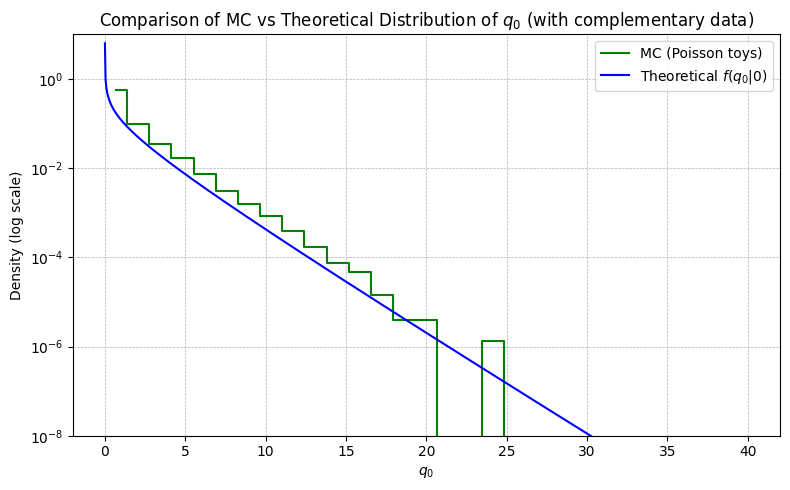

In [13]:
# plot the MC simulated distribution
bins = np.linspace(0, 40, 30)
hist, edges = np.histogram(q0_mc1, bins=bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])
plt.figure(figsize=(8, 5))
plt.step(centers, hist, where='mid', label='MC (Poisson toys)', color='green')

# asymptotic theory distribution  [Cowan]
q0_vals = np.linspace(0.001, 40, 1000)
pdf_theory = f_q0_given_0(q0_vals)
plt.plot(q0_vals, pdf_theory, 'b-', label='Theoretical $f(q_0|0)$')

# plots to compare both 
plt.yscale('log')
plt.ylim((1e-8,10))
plt.xlabel(r'$q_0$')
plt.ylabel('Density (log scale)')
plt.title('Comparison of MC vs Theoretical Distribution of $q_0$ (with complementary data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [14]:
def f_q0_given_mu(q0, mu=0.0):
    """
    Compute the asymptotic PDF f(q0 | mu').

    Parameters
    ----------
    q0 : array_like
        Input values for which the conditional density f(q0 | mu') is evaluated.
    mu_prime : float, optional
        True signal strength under H1. 
        mu_prime = 0 corresponds to background-only (f(q0|0)).

    Returns
    -------
    pdf : ndarray
        Probability density values of f(q0 | mu') evaluated at q0.
    """
    q0 = np.asarray(q0)
    result = np.zeros_like(q0, dtype=np.float64)

    # Dirac delta term at q0 = 0
    delta_flag = (q0 == 0)
    result[delta_flag] = norm.cdf(-mu)

    # Continuous part for q0 > 0
    cont_flag = (q0 > 0)
    q0_pos = q0[cont_flag]
    sqrt_q0 = np.sqrt(q0_pos)
    result[cont_flag] = (1 / (2 * np.sqrt(2 * np.pi * q0_pos)) * (np.exp(-0.5 * (sqrt_q0 - mu)**2) + np.exp(-0.5 * (sqrt_q0 + mu) ** 2)))
    
    return result

In [15]:
# parameters
mu = 1  # for q0

In [16]:
q0_mc2 = MonteCarloSim(b, s, n_events, tau, mu)

/tmp/ipykernel_6019/189110216.py:13: RuntimeWarning: divide by zero encountered in log
  (m*np.log(tau*b_hat)-(tau*b_hat))
/tmp/ipykernel_6019/189110216.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  (m*np.log(tau*b_hat)-(tau*b_hat))


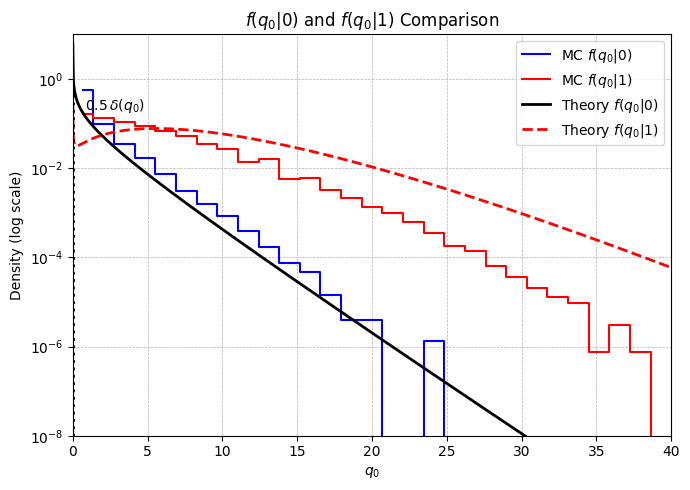

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- Monte Carlo histogram data ---
bins = np.linspace(0, 40, 30)
centers = 0.5 * (bins[:-1] + bins[1:])
hist1, _ = np.histogram(q0_mc1, bins=bins, density=True)
hist2, _ = np.histogram(q0_mc2, bins=bins, density=True)

plt.figure(figsize=(7,5))

# --- MC histograms ---
plt.step(centers, hist1, where='mid', color='blue', lw=1.5, label='MC $f(q_0|0)$')
plt.step(centers, hist2, where='mid', color='red', lw=1.5, label='MC $f(q_0|1)$')

# --- Theoretical curves ---
q0_vals = np.linspace(0.001, 40, 1000)
pdf_theory0 = f_q0_given_0(q0_vals)

q0_asimov = 2 * ((s + b) * np.log(1 + s / b) - s)
Z0 = np.sqrt(q0_asimov)
pdf_theory1 = f_q0_given_mu(q0_vals, mu=Z0)

plt.plot(q0_vals, pdf_theory0, 'k-', lw=2, label='Theory $f(q_0|0)$')
plt.plot(q0_vals, pdf_theory1, 'r--', lw=2, label='Theory $f(q_0|1)$')

# --- Dirac delta representation (mass at q0=0) ---
plt.vlines(0, 1e-8, 0.5, colors='k', linestyles='dotted', lw=2)
plt.text(0.8, 0.2, r'$0.5\,\delta(q_0)$', color='k')

# --- Axes and layout ---
plt.yscale('log')
plt.xlim(0, 40)
plt.ylim(1e-8, 10)
plt.xlabel(r'$q_0$')
plt.ylabel('Density (log scale)')
plt.title(r'$f(q_0|0)$ and $f(q_0|1)$ Comparison')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Fig 5a (Upper limit $q_1$ estimator)

In [25]:
def q1_estimator(n, m, s, mu, tau, mu_hat, b_hat, b_hat_mu):
    # agregar documentacion [english]
    ''' like_cond = ((mu * s + b_hat_mu) ** n * np.exp(-(mu * s + b_hat_mu))) * 
                ((tau * b_hat_mu) ** m * np.exp(-(tau * b_hat_mu))) '''
    
    log_like_cond = (n*np.log(mu*s+b_hat_mu)-(mu*s+b_hat_mu)) + \
                    (m*np.log(tau*b_hat_mu)-(tau*b_hat_mu))
    
    ''' like_max = ((mu_hat * s + b_hat) ** n * np.exp(-(mu_hat * s + b_hat))) * 
               ((tau * b_hat) ** m * np.exp(-(tau * b_hat))) '''
    
    log_like_max = (n*np.log(mu_hat*s+b_hat)-(mu_hat*s+b_hat)) +  \
                    (m*np.log(tau*b_hat)-(tau*b_hat)) 
    
    # -2.0 * np.log(like_cond / like_max)
  
    result = -2.0*(log_like_cond-log_like_max)
    
    return result 

In [38]:
# parameters
b = 10
s = 10
n_events = 1000000
tau = 1
mu_prime = 0 

In [39]:
def MonteCarloSim_1(b, s, n_events, tau, mu_prime = 0):    
    # Monte Carlo simulation under H0 (mu_prime = 0)
    # that is, we are assuming that in the data there is no signal f(q1|0)
    np.random.seed(42)
    n_obs = np.random.poisson(lam=mu_prime*s + b, size=n_events)
    m_obs = np.random.poisson(lam=tau * b,  size=n_events)
    q0_mc = np.zeros(n_events)

    for i in range(n_events):
        n = n_obs[i]
        m = m_obs[i]

        mu_hat =  (n - m / tau) / s
        b_hat = m / tau

        mu_test =1
        first_term = (n + m - (1 + tau) * mu_test * s) / (2 * (1 + tau))
        second_term = ((n + m - (1 + tau) * mu_test * s) ** 2 + 4 * (1 + tau) * m * mu_test * s) / (4 * (1 + tau) ** 2)
        b_hat_mu = first_term + np.sqrt(second_term)

        if mu_hat <= mu_test:
            q0_mc[i] = q1_estimator(n, m, s, mu_test, tau, mu_hat, b_hat, b_hat_mu)
            
    return q0_mc

In [40]:
def sigma_asimov_mu(mu, mu_prime, s, b):
    """
    Write Documentation
    """
    # Asimov dataset sigma  Ec. [30, 31, 32]
   # Ec. 30 tells that is zero, but we define it as 1 for usability [for students: why this works?]
    
    # Asimov data set
    nA = mu_prime * s + b
    mA = tau * b
    # Asimov estimators
    mu_hat_A = (nA - mA / tau) / s # we allow negative values. check paper
    b_hat_A = mA / tau
    first_term_A = (nA + mA - (1 + tau) * mu * s) / (2 * (1 + tau))
    second_term_A = ((nA + mA - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * mA * mu * s) / (4 * (1 + tau) ** 2)
    b_hat_mu_A = first_term_A + np.sqrt(second_term_A)
    # Asimov sigma [Eq. 32]
    sigmaA = np.sqrt(((mu - mu_prime)**2)/q1_estimator(nA, mA, s, mu, tau, mu_hat_A, b_hat_A, b_hat_mu_A))
    return sigmaA

In [41]:
def f_q1_given_mu_prime(q1,sigma,mu , mu_prime):
    """
    Compute the asymptotic PDF f(q0 | mu').

    Parameters
    ----------
    q1 : array_like
        Input values for which the conditional density f(q0 | mu') is evaluated.
    mu_prime : float, optional
        True signal strength under H1. 
        mu_prime = 0 corresponds to background-only (f(q0|0)).

    Returns
    -------
    pdf : ndarray
        Probability density values of f(q0 | mu') evaluated at q0.
    """
    
    q1 = np.asarray(q1)
    result = np.zeros_like(q1, dtype=np.float64)

    # Dirac delta term at q1 = 0
    delta_flag = (q1 == 0 )
    
    result[delta_flag] = norm.cdf((mu_prime-mu)/sigma )

    # Continuous part for q1 > 0
    cont_flag = (q1 > 0)
    q1_pos = q1[cont_flag]
    sqrt_q1 = np.sqrt(q1_pos)
    if mu == mu_prime:
        result[cont_flag] = (1 / (2 * np.sqrt(2 * np.pi * q1_pos)) * (np.exp(-0.5 * (sqrt_q1 )**2)))
    else:
        result[cont_flag] = (1 / (2 * np.sqrt(2 * np.pi * q1_pos)) * (np.exp(-0.5 * (sqrt_q1 - ((mu-mu_prime)/sigma))**2)))
    
    return result

In [42]:
q1_mc0 = MonteCarloSim_1(b=b,s=s,n_events=n_events,tau=tau,mu_prime= 0)
q1_mc1 = MonteCarloSim_1(b=b,s=s,n_events=n_events,tau=tau,mu_prime= 1)

/tmp/ipykernel_6019/2364891088.py:12: RuntimeWarning: divide by zero encountered in log
  log_like_max = (n*np.log(mu_hat*s+b_hat)-(mu_hat*s+b_hat)) +  \
/tmp/ipykernel_6019/2364891088.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  log_like_max = (n*np.log(mu_hat*s+b_hat)-(mu_hat*s+b_hat)) +  \
/tmp/ipykernel_6019/2364891088.py:7: RuntimeWarning: divide by zero encountered in log
  (m*np.log(tau*b_hat_mu)-(tau*b_hat_mu))
/tmp/ipykernel_6019/2364891088.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  (m*np.log(tau*b_hat_mu)-(tau*b_hat_mu))
/tmp/ipykernel_6019/2364891088.py:13: RuntimeWarning: divide by zero encountered in log
  (m*np.log(tau*b_hat)-(tau*b_hat))
/tmp/ipykernel_6019/2364891088.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  (m*np.log(tau*b_hat)-(tau*b_hat))


/tmp/ipykernel_6019/3677213807.py:18: RuntimeWarning: invalid value encountered in scalar divide
  sigmaA = np.sqrt(((mu - mu_prime)**2)/q1_estimator(nA, mA, s, mu, tau, mu_hat_A, b_hat_A, b_hat_mu_A))


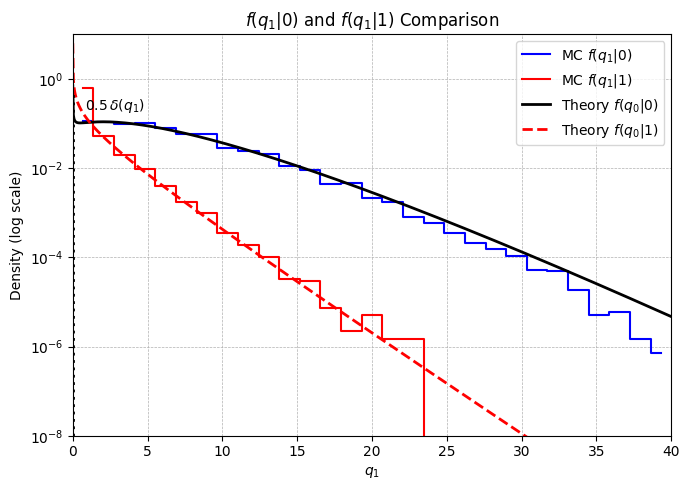

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Monte Carlo histogram data ---
bins = np.linspace(0, 40, 30)
centers = 0.5 * (bins[:-1] + bins[1:])
hist1, _ = np.histogram(q1_mc0, bins=bins, density=True)
hist2, _ = np.histogram(q1_mc1, bins=bins, density=True)

plt.figure(figsize=(7,5))

# --- MC histograms ---
plt.step(centers, hist1, where='mid', color='blue', lw=1.5, label='MC $f(q_1|0)$')
plt.step(centers, hist2, where='mid', color='red', lw=1.5, label='MC $f(q_1|1)$')

# --- Theoretical curves ---
q1_vals = np.linspace(0.001, 40, 1000)
pdf_theory0 = f_q1_given_mu_prime(q1_vals,sigma=sigma_asimov_mu(mu = 1,mu_prime=0,s=s,b=b),mu=1,mu_prime=0) #f(q1|0)
pdf_theory1 = f_q1_given_mu_prime(q1_vals,sigma=sigma_asimov_mu(mu = 1,mu_prime=1,s=s,b=b),mu=1,mu_prime=1) #f(q1|1)

plt.plot(q1_vals, pdf_theory0, 'k-', lw=2, label='Theory $f(q_0|0)$')
plt.plot(q1_vals, pdf_theory1, 'r--', lw=2, label='Theory $f(q_0|1)$')

# --- Dirac delta representation (mass at q0=0) ---
plt.vlines(0, 1e-8, 0.5, colors='k', linestyles='dotted', lw=2)
plt.text(0.8, 0.2, r'$0.5\,\delta(q_1)$', color='k')

# --- Axes and layout ---
plt.yscale('log')
plt.xlim(0, 40)
plt.ylim(1e-8, 10)
plt.xlabel(r'$q_1$')
plt.ylabel('Density (log scale)')
plt.title(r'$f(q_1|0)$ and $f(q_1|1)$ Comparison')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Fig 5b (Upper limit $\tilde{q}_1$ estimator)